Notebook con resultados de las interpolaciones y gráficos de error durante el entrenamiento

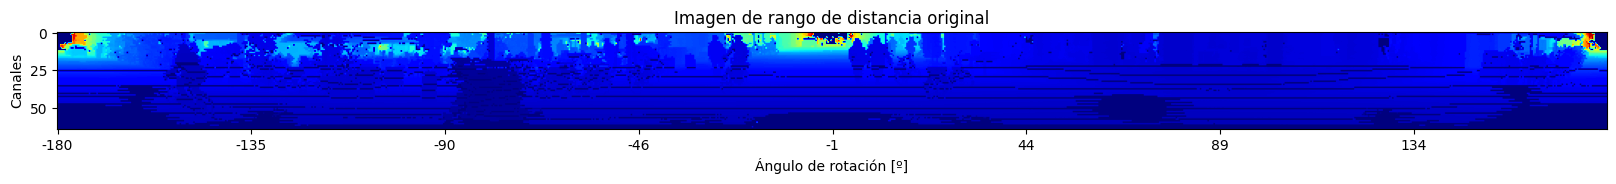

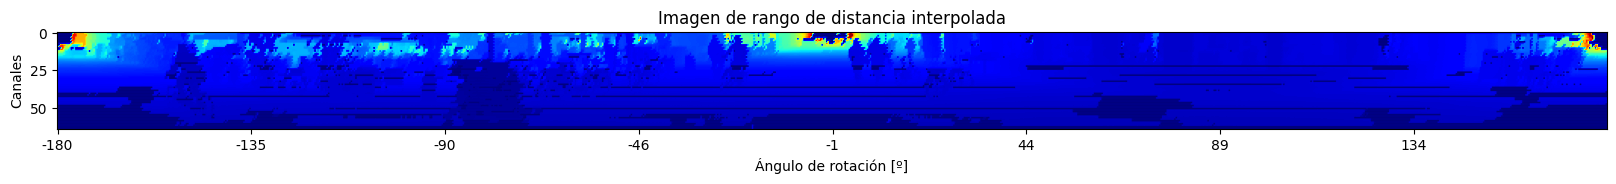

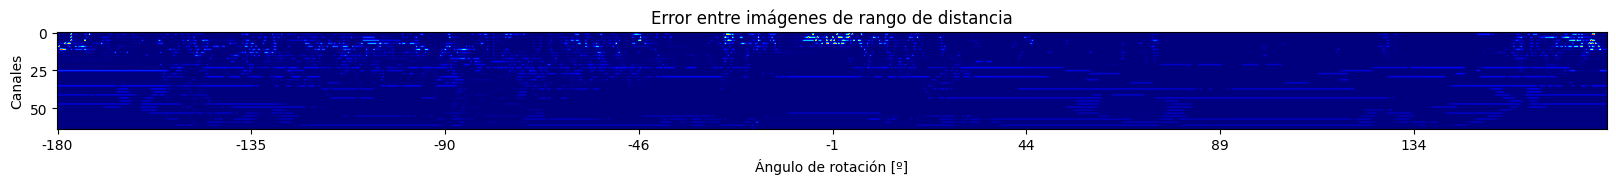

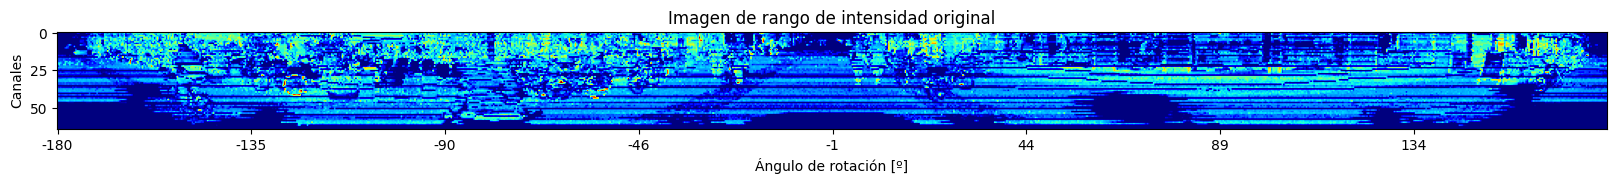

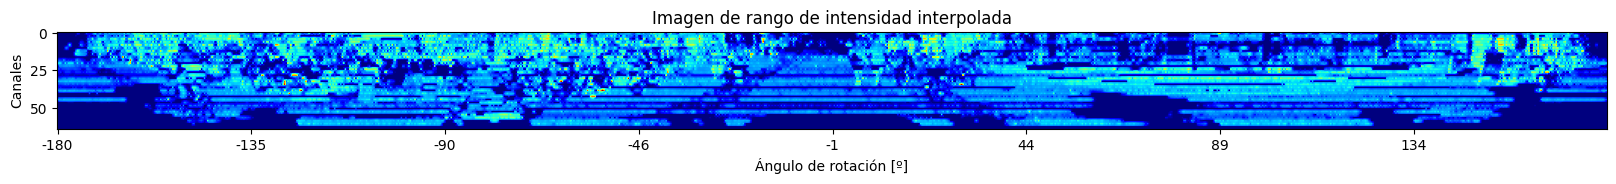

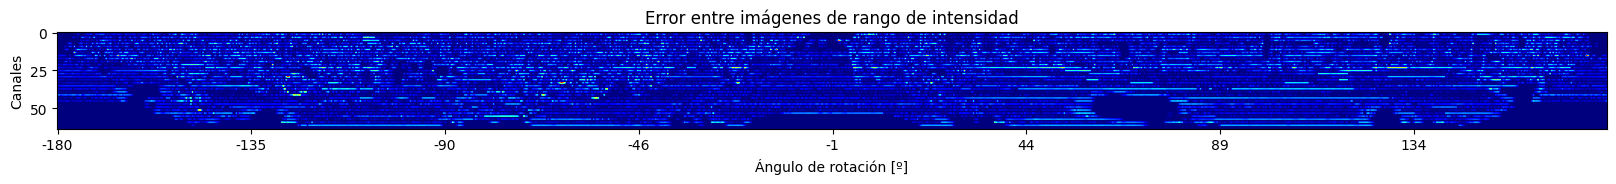

In [5]:
import sys
import matplotlib.pyplot as plt
from pointcloud_utils_functions_v2 import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from pointcloud_utils_functions_v2 import *
device = "cuda" if torch.cuda.is_available() else "cpu"

kitti_pointcloud_path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\training\velodyne\001068.bin'
kitti_image_path = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\training\image_2\001068.png'
save_model_distance_path = r'.\models_result\model_cnn1d_min_82-12_Chamfer_sinnorm_no_ego_filtered.pth'
save_model_intensity_path = r'.\models_result\model_cnn1d_min_82-12_Chamfer_sinnorm_no_ego_filtered_intensity.pth'

pointcloud = read_bin(kitti_pointcloud_path)
range_distance_image = pointcloud_to_range_image(pointcloud, filter_ego_compensed=False, size=(64,1024), kind = 'distance')
range_intensity_image = pointcloud_to_range_image(pointcloud, filter_ego_compensed=False, size=(64,1024), kind='intensity')

indexes = range(0, 64, 2)
lrimg_distance = torch.from_numpy(range_distance_image[indexes])
lrimg_intensity = torch.from_numpy(range_intensity_image[indexes])

hrimg_distance = torch.from_numpy(range_distance_image)
hrimg_intensity = torch.from_numpy(range_intensity_image)

class Approx_net(nn.Module):    
    def __init__(self, input_channels, input_features, conv_filters_1, conv_filters_2, linear_features):
        super(Approx_net, self).__init__()
        #cnn layer
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=conv_filters_1, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=conv_filters_1, out_channels=conv_filters_2, kernel_size=1)
        # hidden layer
        self.linear_1 = nn.Linear(in_features=conv_filters_2*input_features+1, out_features=linear_features) #Para considerar el mínimo, se suma 1 a la entrada
        self.linear_2 = nn.Linear(in_features=linear_features, out_features=1)
        
        self.act = nn.LeakyReLU()
        self.act1 = nn.ReLU()
    
    # prediction function
    def forward(self, x):
        min_value, _ = x.min(dim=1)
        x = x.unsqueeze(1)
        x_ = self.conv1(x)
        x_ = self.conv2(x_)
        x_ = x_.view(x.size(0), -1)
        x_ = torch.hstack((x_, min_value.unsqueeze(1)))
        x_ = self.act(self.linear_1(x_))
        y = self.act1(self.linear_2(x_))
        return y

def get_windows(x, upscaling_factor=2):
    kernel_size = (2,3)
    padding = (0,1)
    stride = (1,1)
    
    if upscaling_factor == 2:
        windows = F.unfold(x, kernel_size=kernel_size, padding=padding, stride=stride)
        windows = windows.transpose(1, 2) #Obtener los valores de la ventana o kernel ordenados por fila, donde cada fila representa una ventana serializada
        windows = windows.to(device)
    else:
        print("ERROR: Wrong Upsampling factor")
    return windows 

model_distance = Approx_net(input_channels=1, input_features=6, conv_filters_1=8, conv_filters_2=2, linear_features=12)
model_distance.load_state_dict(torch.load(save_model_distance_path))
model_distance.to(device)

model_intensity = Approx_net(input_channels=1, input_features=6, conv_filters_1=8, conv_filters_2=2, linear_features=12)
model_intensity.load_state_dict(torch.load(save_model_intensity_path))
model_intensity.to(device)

lrimg_distance = lrimg_distance.unsqueeze(0).unsqueeze(0)
lrimg_intensity = lrimg_intensity.unsqueeze(0).unsqueeze(0)
lrimg_distance = lrimg_distance.to(device)
lrimg_intensity = lrimg_intensity.to(device)

hrimg_distance = hrimg_distance.unsqueeze(0).unsqueeze(0)
hrimg_intensity = hrimg_intensity.unsqueeze(0).unsqueeze(0)
hrimg_distance = hrimg_distance.to(device)
hrimg_intensity = hrimg_intensity.to(device)


twindows_distance = get_windows(lrimg_distance)
twindows_distance_stack = twindows_distance.reshape(twindows_distance.shape[0] * twindows_distance.shape[1], twindows_distance.shape[2])
pixels_distance = model_distance(twindows_distance_stack)
pixels_distance = pixels_distance.view(lrimg_distance.shape[0], lrimg_distance.shape[1], -1, lrimg_distance.shape[-1])
toutputs_distance = torch.zeros_like(hrimg_distance, device=device, dtype=torch.double)
toutputs_distance[:,:,:toutputs_distance.shape[2]:2, :toutputs_distance.shape[3]] = lrimg_distance
toutputs_distance[:,:,1:toutputs_distance.shape[2]-1:2, :toutputs_distance.shape[3]] = pixels_distance
toutputs_distance = torch.dstack((toutputs_distance[:,:,:-1,:], lrimg_distance[:,:,-1:,:])) #Repito la última fila     

twindows_intensity = get_windows(lrimg_intensity)
twindows_intensity_stack = twindows_intensity.reshape(twindows_intensity.shape[0] * twindows_intensity.shape[1], twindows_intensity.shape[2])
pixels_intensity = model_intensity(twindows_intensity_stack)
pixels_intensity = pixels_intensity.view(lrimg_intensity.shape[0], lrimg_intensity.shape[1], -1, lrimg_intensity.shape[-1])
toutputs_intensity = torch.zeros_like(hrimg_intensity, device=device, dtype=torch.double)
toutputs_intensity[:,:,:toutputs_intensity.shape[2]:2, :toutputs_intensity.shape[3]] = lrimg_intensity
toutputs_intensity[:,:,1:toutputs_intensity.shape[2]-1:2, :toutputs_intensity.shape[3]] = pixels_intensity
toutputs_intensity = torch.dstack((toutputs_intensity[:,:,:-1,:], lrimg_intensity[:,:,-1:,:]))

output_distance = toutputs_distance[0,0,...].detach().cpu().numpy()
output_intensity = toutputs_intensity[0,0,...].detach().cpu().numpy()


distance_error_image = np.abs(output_distance - range_distance_image)
intensity_error_image = np.abs(output_intensity - range_intensity_image)

def display_range_image(img, h_res=0.35, v_fov=(-24.9, 2.0), h_fov=(-180, 180), cmap='jet', title='Ejemplo'):
    '''
    img: range image
    h_res: horizontal resolution
    v_fov: vertical field of view (ej: (-24.9,2.0))
    h_fov: horizontal field of view (ej: (-180,180))
    '''
    def scale_xaxis(axis_value, *args):
        if h_fov[0] > 0:
            return int(np.round((axis_value * h_res + h_fov[0])))
        else:
            return int(np.round((axis_value * h_res - abs(h_fov[0]))))

    plt.subplots(1,1, figsize = (20,10))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.xticks(np.arange(0,len(img[1]),len(img[1])/8))
    formatter = FuncFormatter(scale_xaxis)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xlabel("Ángulo de rotación [º]")
    plt.ylabel("Canales")
    plt.show()

display_range_image(range_distance_image, title="Imagen de rango de distancia original")
display_range_image(output_distance, title="Imagen de rango de distancia interpolada")
display_range_image(distance_error_image, title="Error entre imágenes de rango de distancia")

display_range_image(range_intensity_image, title="Imagen de rango de intensidad original")
display_range_image(output_intensity, title="Imagen de rango de intensidad interpolada")
display_range_image(intensity_error_image, title="Error entre imágenes de rango de intensidad")

### Gráfico de pérdidas en función de las épocas

In [2]:
train_txt_file_path_distance = r'.\models_result\model_cnn1d_min_82-12_Chamfer_sinnorm_no_ego_filtered.txt'
train_txt_file_path_intensity = r'.\models_result\model_cnn1d_min_82-12_Chamfer_sinnorm_no_ego_filtered_intensity.txt'

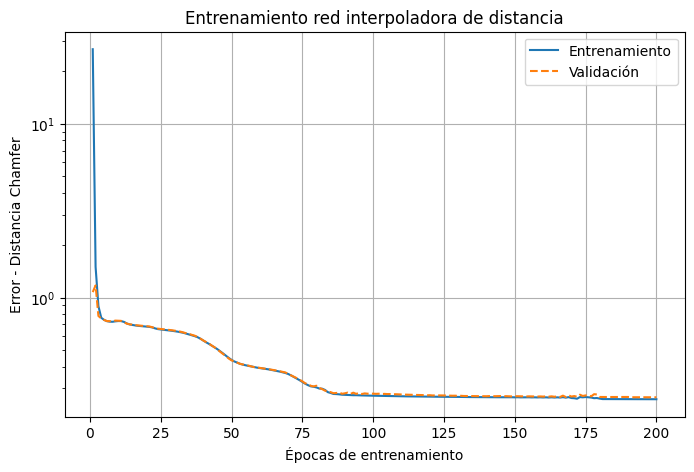

In [5]:
with open(train_txt_file_path_distance, 'r') as f:
    lines = [lines.strip().split(sep='-') for lines in f.readlines()] #['Epoch 1 ', ' Train_loss: 26.75810404062271 ', ' Valid_loss: 1.0743010759353637 ', ' lr: 0.01]
    train_losses = [float(data[1].split(sep=':')[1].strip()) for data in lines]
    valid_losses = [float(data[2].split(sep=':')[1].strip()) for data in lines]

epochs = list(range(1, len(lines)+1))

epochs = epochs[:200]
train_losses = train_losses[:200]
valid_losses = valid_losses[:200]

plt.figure(figsize=(8,5))
plt.semilogy(epochs, train_losses, label='Entrenamiento')
plt.semilogy(epochs, valid_losses, label='Validación', linestyle='--')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error - Distancia Chamfer')
plt.title('Entrenamiento red interpoladora de distancia')
plt.grid()
plt.legend()
plt.show()


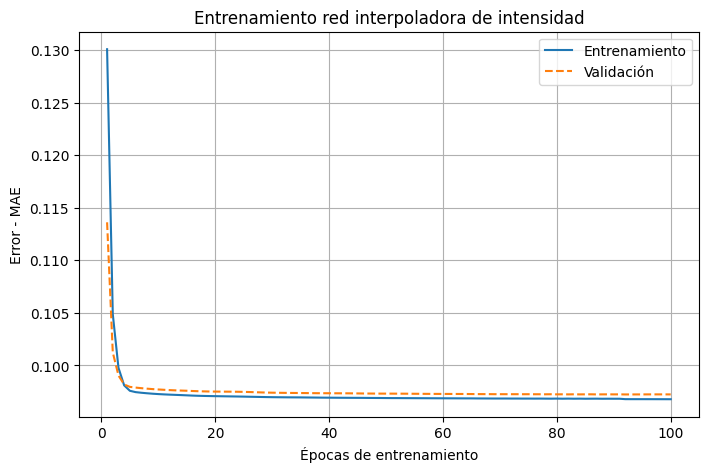

In [7]:
with open(train_txt_file_path_intensity, 'r') as f:
    lines = [lines.strip().split(sep='-') for lines in f.readlines()] #['Epoch 1 ', ' Train_loss: 26.75810404062271 ', ' Valid_loss: 1.0743010759353637 ', ' lr: 0.01]
    train_losses = [float(data[1].split(sep=':')[1].strip()) for data in lines]
    valid_losses = [float(data[2].split(sep=':')[1].strip()) for data in lines]

epochs = list(range(1, len(lines)+1))

epochs = epochs[:100]
train_losses = train_losses[:100]
valid_losses = valid_losses[:100]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Entrenamiento')
plt.plot(epochs, valid_losses, label='Validación', linestyle='--')
plt.xlabel('Épocas de entrenamiento')
plt.ylabel('Error - MAE')
plt.title('Entrenamiento red interpoladora de intensidad')
plt.grid()
plt.legend()
plt.show()